<a href="https://colab.research.google.com/github/manel98daboussi/NLP/blob/main/__NLP___.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici les descriptions et les noms de produits)
* L'objectif est de pouvoir séparer les produits de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte 
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fichier des produits

path = '/content/drive/MyDrive/Projet1/' # à adapter = répertoire de stockage du dataset
data_T0 = pd.read_csv(path + "flipkart_com-ecommerce_sample_1050.csv")
print(data_T0.shape)

(1050, 15)


##  Data extraction

###  Data Overview

Size of the dataframe

In [ ]:
data_T0.shape

(1050, 15)

Names of the columns

In [ ]:
data_T0.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

Description of the content

In [ ]:
data_T0.describe(include='all')

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1049.000000,1049.000000,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,NaN,NaN,1050,2,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,NaN,NaN,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,NaN,NaN,1,993,1,889,889,11,22
mean,NaN,NaN,NaN,NaN,NaN,NaN,2186.197331,1584.527169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,7639.229411,7475.099680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,555.000000,340.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,999.000000,600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,1999.000000,1199.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Categories

Unfolding categories using the 'product_category_tree' colum

In [ ]:
# Sample checking

data_T0['product_category_tree'][743]

'["Kitchen & Dining >> Containers & Bottles >> Bottles & Sippers >> Water bottle >> Nutcase Water bottle"]'

In [ ]:
# Determining the maximum tree depth of categories

ser_depth = data_T0['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()
max_depth

6

In [ ]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = data_T0['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
data_T0_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=data_T0.index)

In [ ]:
# printing number of categories in each level and a sample
display(data_T0_cat_level.nunique(), data_T0_cat_level.sample(3))

cat_level_0      7
cat_level_1     62
cat_level_2    243
cat_level_3    460
cat_level_4    596
cat_level_5    633
dtype: int64

,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5
533,Watches,Watches/Wrist Watches,Watches/Wrist Watches/Sonata Wrist Watches,Watches/Wrist Watches/Sonata Wrist Watches/,Watches/Wrist Watches/Sonata Wrist Watches//,Watches/Wrist Watches/Sonata Wrist Watches///
298,Kitchen & Dining,Kitchen & Dining/Kitchen Tools,Kitchen & Dining/Kitchen Tools/Kitchen Implements,Kitchen & Dining/Kitchen Tools/Kitchen Impleme...,Kitchen & Dining/Kitchen Tools/Kitchen Impleme...,Kitchen & Dining/Kitchen Tools/Kitchen Impleme...
487,Computers,Computers/Laptop Accessories,Computers/Laptop Accessories/Batteries,Computers/Laptop Accessories/Batteries/Lapguar...,Computers/Laptop Accessories/Batteries/Lapguar...,Computers/Laptop Accessories/Batteries/Lapguar...


Let's see how much items are in each category

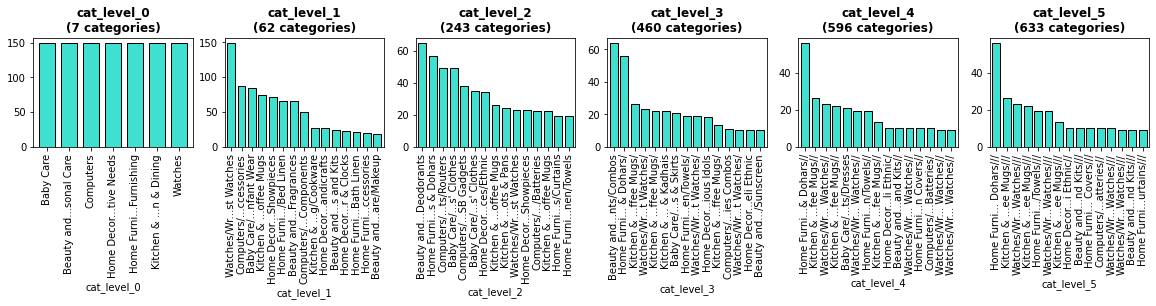

In [ ]:
shorten_label = 10
n_first = 15
fig = plt.figure(figsize=(20,2))
for i, col in enumerate(data_T0_cat_level.columns,1):
    # plot the graphs
    ax = fig.add_subplot(1,len(data_T0_cat_level.columns), i)
    ser = data_T0_cat_level.groupby(col).size().sort_values(ascending=False)
    ser[0:n_first].plot.bar(width=0.75, color='turquoise', ec='k', ax=ax)
    # shorten the labels
    thr = int(shorten_label)
    lab_x = [item.get_text() for item in ax.get_xticklabels()]
    short_lab_x = [s[:thr]+'...'+s[-thr:] if len(s)>thr else s for s in lab_x]
    ax.axes.set_xticklabels(short_lab_x)
    # set title
    ax.set_title(col+f'\n({ser.shape[0]} categories)', fontweight='bold')

The only level that has a balanced set of items is level 0, with 7 categories.
Let's rename these 7 categories:

In [ ]:
data_T0_cat_level['cat_level_0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [ ]:
data_T0_cat_level['category'] = \
    data_T0_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                         'Baby Care': 'Baby', 
                                         'Watches': 'Watches',
                                         'Home Decor & Festive Needs': 'Decor',
                                         'Kitchen & Dining': 'Kitchen',
                                         'Beauty and Personal Care': 'Beauty',
                                         'Computers': 'Computers'})

###  Products descriptions and product names

In [ ]:
# Extract only useful data

data_T0_desc_cat = pd.concat([data_T0_cat_level['category'],
                         data_T0[["product_name", "description"]]], axis=1)

In [ ]:
data_T0_desc_cat.head(1)

,category,product_name,description
0,Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...


Have a look to one particular item

In [ ]:
# creation of a corpus of all the descriptions
corpus = ' '.join(data_T0_desc_cat['description'].values)
print("Nombre total des mots dans le corpus: ", len(corpus.split()))

Nombre total des mots dans le corpus:  80013


## Nettoyage du texte

In [ ]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import io
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idata_T0, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text
#Description
data_T0_desc_cat['description_bow'] = data_T0['description'].apply(lambda x : transform_bow_fct(x))
data_T0_desc_cat['description_bow_lem'] = data_T0['description'].apply(lambda x : transform_bow_lem_fct(x))
data_T0_desc_cat['description_dl'] = data_T0['description'].apply(lambda x : transform_dl_fct(x))
#Product_Name
data_T0_desc_cat['product_name_bow'] = data_T0['product_name'].apply(lambda x : transform_bow_fct(x))
data_T0_desc_cat['product_name_bow_lem'] = data_T0['product_name'].apply(lambda x : transform_bow_lem_fct(x))
data_T0_desc_cat['product_name_dl'] = data_T0['product_name'].apply(lambda x : transform_dl_fct(x))
data_T0_desc_cat.shape

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


(1050, 9)

In [ ]:
data_T0_desc_cat.to_csv("dataset2_clean.csv")

# Préparation commune des traitements

In [ ]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [ ]:
data_T =  pd.read_csv("/content/drive/MyDrive/Projet1/dataset2_clean.csv")
print(data_T.shape)
data_T.head()

(1050, 12)


,Unnamed: 0,category,product_name,description,sentence_bow,description_bow,description_bow_lem,description_dl,produc_name_bow,product_name_bow_lem,product_name_dl,product_name_bow
0,0,Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,key features elegance polyester multicolor abs...,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...
1,1,Baby,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,specifications sathiyas cotton bath towel bath...,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,sathiyas cotton bath towel,sathiyas cotton bath towel,sathiyas cotton bath towel,sathiyas cotton bath towel
2,2,Baby,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,key features eurospa cotton terry face towel s...,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...,eurospa cotton terry face towel set,eurospa cotton terry face towel set,eurospa cotton terry face towel set,eurospa cotton terry face towel set
3,3,Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,key features santosh royal fashion cotton prin...,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...
4,4,Furnishing,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,key features jaipur print cotton floral king s...,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...


In [ ]:
l_cat = list(set(data_T['category']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['category'])) for i in range(len(data_T))]

catégories :  ['Baby', 'Watches', 'Decor', 'Computers', 'Beauty', 'Kitchen', 'Furnishing']


In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
#Description
print("*********Description********")
data_T['desc_length_bow'] = data_T['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['desc_length_bow'].max())
data_T['desc_length_dl'] = data_T['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['desc_length_bow'].max())
#Product_name
print("*********Product_Name********")
data_T['pName_length_bow'] = data_T['product_name_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['pName_length_bow'].max())
data_T['pName_length_dl'] = data_T['product_name_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['pName_length_dl'].max())



*********Description********
max length bow :  379
max length dl :  379
*********Product_Name********
max length bow :  24
max length dl :  30


## Fonctions communes

In [ ]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)


# Bag of word - Tf-idf

## Préparation sentences

In [ ]:
# création du bag of words (CountVectorizer et Tf-idata_T0)

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat1 = 'description_bow_lem'
feat2='product_name_bow_lem'
cv_fit1 = cvect.fit(data_T[feat1])
ctf_fit1 = ctf.fit(data_T[feat1])
cv_transform1 = cvect.transform(data_T[feat1])  
ctf_transform1 = ctf.transform(data_T[feat1])  
cv_fit2 = cvect.fit(data_T[feat2])
ctf_fit2 = ctf.fit(data_T[feat2])
cv_transform2 = cvect.transform(data_T[feat2])  
ctf_transform2 = ctf.transform(data_T[feat2]) 

## Exécution des modèles

### Description

In [ ]:
print("********Description************")
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform1)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform1)

********Description************
CountVectorizer : 
-----------------
ARI :  0.3859 time :  13.0

Tf-idf : 
--------
ARI :  0.4164 time :  12.0


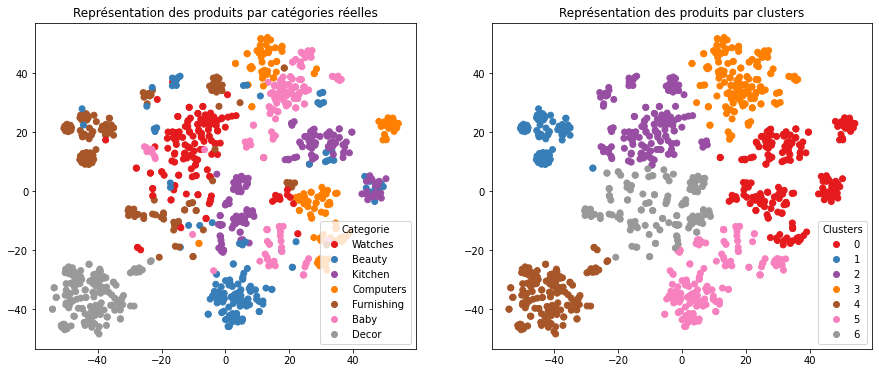

ARI :  0.4164


In [ ]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Nom de produit

In [ ]:
print("********Nom de produit************")
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform2)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform2)

********Nom de produit************
CountVectorizer : 
-----------------
ARI :  0.3423 time :  16.0

Tf-idf : 
--------
ARI :  0.4369 time :  12.0


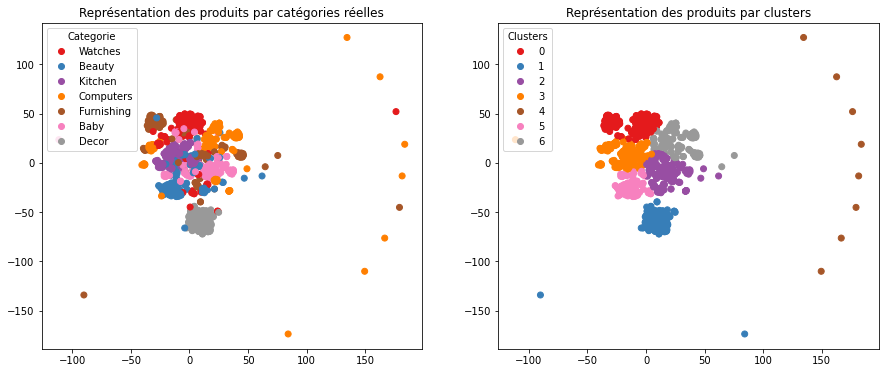

ARI :  0.4369


In [ ]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

### Nom de produit

#### Création du modèle Word2vec

In [ ]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['product_name_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(sentences=sentences,min_count=w2v_min_count, window=w2v_window,
                                               size=w2v_size,
                                                seed=42,
                                                workers=1)

Build & train Word2Vec model ...


In [ ]:
#w2v_model.build_vocab(sentences)
w2v_model.train(sentences=sentences,total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv

In [ ]:
w2v_words = model_vectors.index2word
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 1922
Word2Vec trained


#### Création de la matrice d'embedding

In [ ]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.4078
Embedding matrix: (4714, 300)


#### Création du modèle

In [ ]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 24, 300)           1414200   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,414,200
Trainable params: 1,414,200
Non-trainable params: 0
_________________________________________________________________


#### Execution du modèle

In [ ]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(1050, 300)

In [ ]:
print("********Product_Name************")
ARI, X_tsne, labels = ARI_fct(embeddings)

********Product_Name************
ARI :  0.3646 time :  33.0


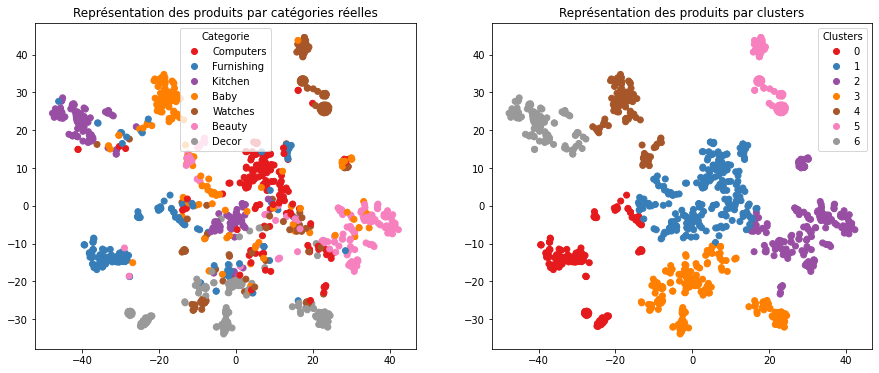

ARI :  0.3646


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Description

#### Création du modèle Word2vec

In [ ]:
#Description
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['description_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(sentences=sentences,min_count=w2v_min_count, window=w2v_window,
                                               size=w2v_size,
                                                seed=42,
                                                workers=1)

Build & train Word2Vec model ...


In [ ]:
#w2v_model.build_vocab(sentences)
w2v_model.train(sentences=sentences,total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv

In [ ]:
w2v_words = model_vectors.index2word
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 4713
Word2Vec trained


In [ ]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4714


#### Création de la matrice d'embedding

In [ ]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4714, 300)


#### Création du modèle d'embedding

In [ ]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1414200   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,414,200
Trainable params: 1,414,200
Non-trainable params: 0
_________________________________________________________________


#### Exécution du modèle

In [ ]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(1050, 300)

In [ ]:
print("********Description************")
ARI, X_tsne, labels = ARI_fct(embeddings)

********Description************


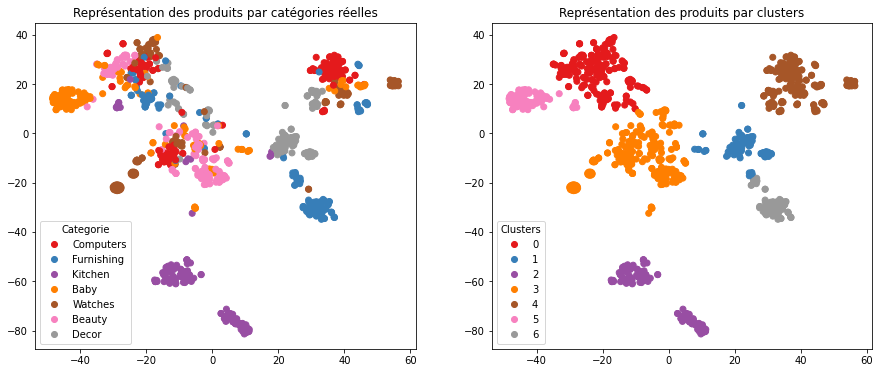

ARI :  0.2781


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)




# BERT

In [ ]:
!pip install transformers[tf-cpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
#from transformers import *
import torch
from transformers import AutoModel, AutoTokenizer, TFAutoModel

os.environ["TF_KERAS"]='1'

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
False


## Fonctions communes

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

#### What is the difference between BERT base cased and uncased?
##### In BERT uncased, the text has been lowercased before WordPiece tokenization step while in BERT cased, the text is same as the input text (no changes)

### bert-base-uncased  

#### Description

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['description_dl'].to_list()

In [ ]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
temps traitement :  284.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3242 time :  16.0


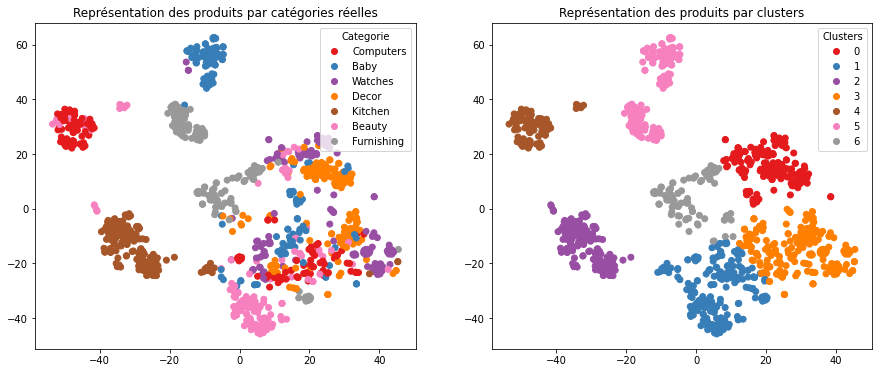

ARI :  0.3242


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### Nom de produit

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['product_name_dl'].to_list()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [ ]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

1/1 [==============================] - 1s 1s/step
temps traitement :  170.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.6344 time :  13.0


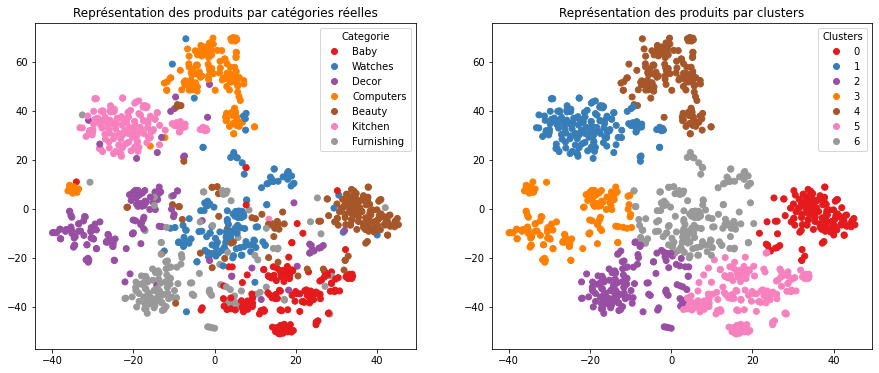

ARI :  0.6344


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [ ]:
! pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
import tensorflow_hub as hub
import tensorflow_text
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

#### Description

In [ ]:
sentences = data_T['description_dl'].to_list()

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  242.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3162 time :  15.0


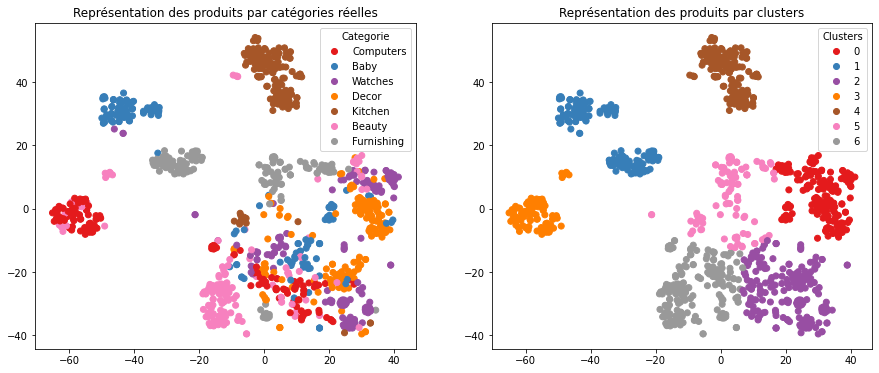

ARI :  0.3162


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### Nom de produit

In [ ]:
sentences = data_T['product_name_dl'].to_list()

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

temps traitement :  230.0


In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.6387 time :  41.0


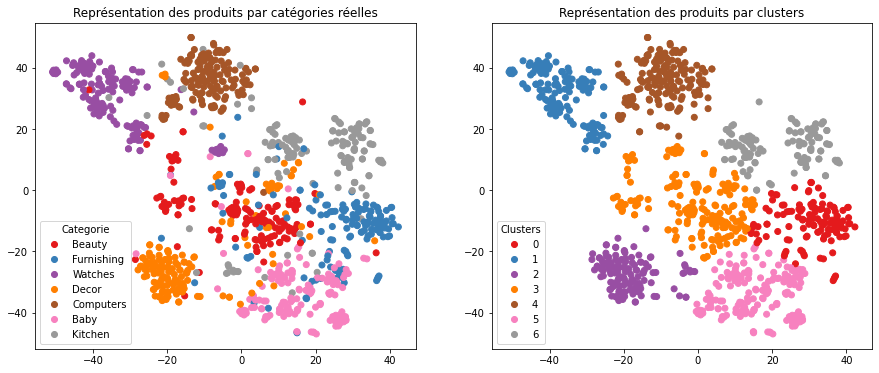

ARI :  0.6387


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model



os.environ["TF_KERAS"]='1'

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
False


In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

### Description

In [ ]:
batch_size = 10
sentences = data_T['description_dl'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.439 time :  15.0


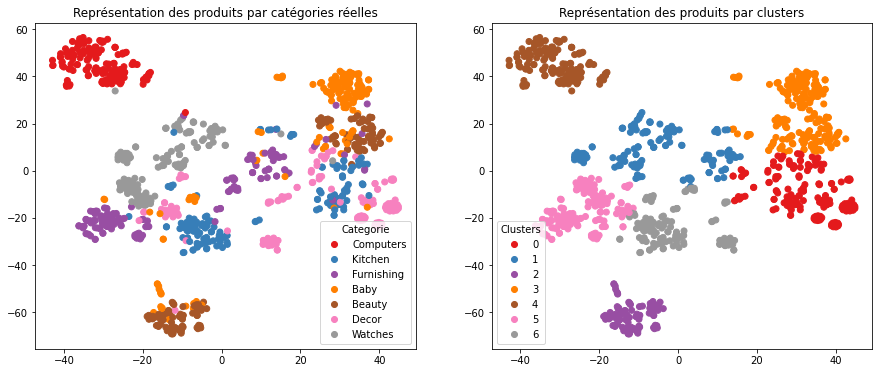

ARI :  0.439


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Nom de produit


In [ ]:
batch_size = 10
sentences = data_T['product_name_dl'].to_list()

In [ ]:
features_USE = feature_USE_fct(sentences, batch_size)

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.6553 time :  13.0


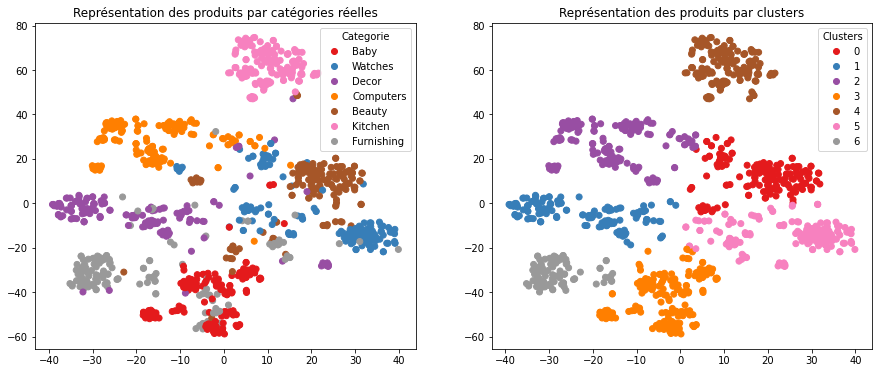

ARI :  0.6553


In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)